In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
#pip install plotnine
#from plotnine import ggplot, aes, peom_line, peom_point, facet_wrap, labs, pgtitle, theme_minimal, scale_y_log10

sns.set_theme(context='paper', style='darkgrid', font='sans-serif', font_scale=1)

In [3]:
data = pd.read_csv("simulation_results_v6.csv")
data.head()

,Density,Population_size,Infectious_time,iter_1,iter_2,iter_3,iter_4,iter_5,iter_6,iter_7,...,iter_91,iter_92,iter_93,iter_94,iter_95,iter_96,iter_97,iter_98,iter_99,iter_100
0,0.01,30,1,1,4,1,3,4,1,1,...,2,1,2,2,2,3,1,3,5,4
1,0.01,30,2,2,12,5,4,1,1,2,...,2,7,3,4,5,6,5,3,4,5
2,0.01,30,3,5,5,8,9,6,4,4,...,10,2,5,5,6,4,8,8,5,7
3,0.01,30,4,11,12,8,7,6,4,3,...,9,5,5,7,2,6,4,6,7,10
4,0.01,30,5,6,14,8,9,7,6,3,...,3,4,8,12,12,9,7,3,8,15


In [4]:
long_data = pd.melt(data, var_name="simulation", value_name="cases", 
                   id_vars=[col for col in data.columns if not col.startswith("iter")])

long_data['cases_per_infectious_time'] = long_data['cases'] / long_data['Infectious_time']
long_data['cases_per_pop_size'] = long_data['cases'] / long_data['Population_size']

long_data['Infectious_time'] = long_data['Infectious_time'].astype('category')
long_data['Population_size'] = long_data['Population_size'].astype('category')
long_data['Density'] = long_data['Density'].astype('category')

print(long_data.dtypes)

long_data.head()

Density                      category
Population_size              category
Infectious_time              category
simulation                     object
cases                           int64
cases_per_infectious_time     float64
cases_per_pop_size            float64
dtype: object


,Density,Population_size,Infectious_time,simulation,cases,cases_per_infectious_time,cases_per_pop_size
0,0.01,30,1,iter_1,1,1.000000,0.033333
1,0.01,30,2,iter_1,2,1.000000,0.066667
2,0.01,30,3,iter_1,5,1.666667,0.166667
3,0.01,30,4,iter_1,11,2.750000,0.366667
4,0.01,30,5,iter_1,6,1.200000,0.200000


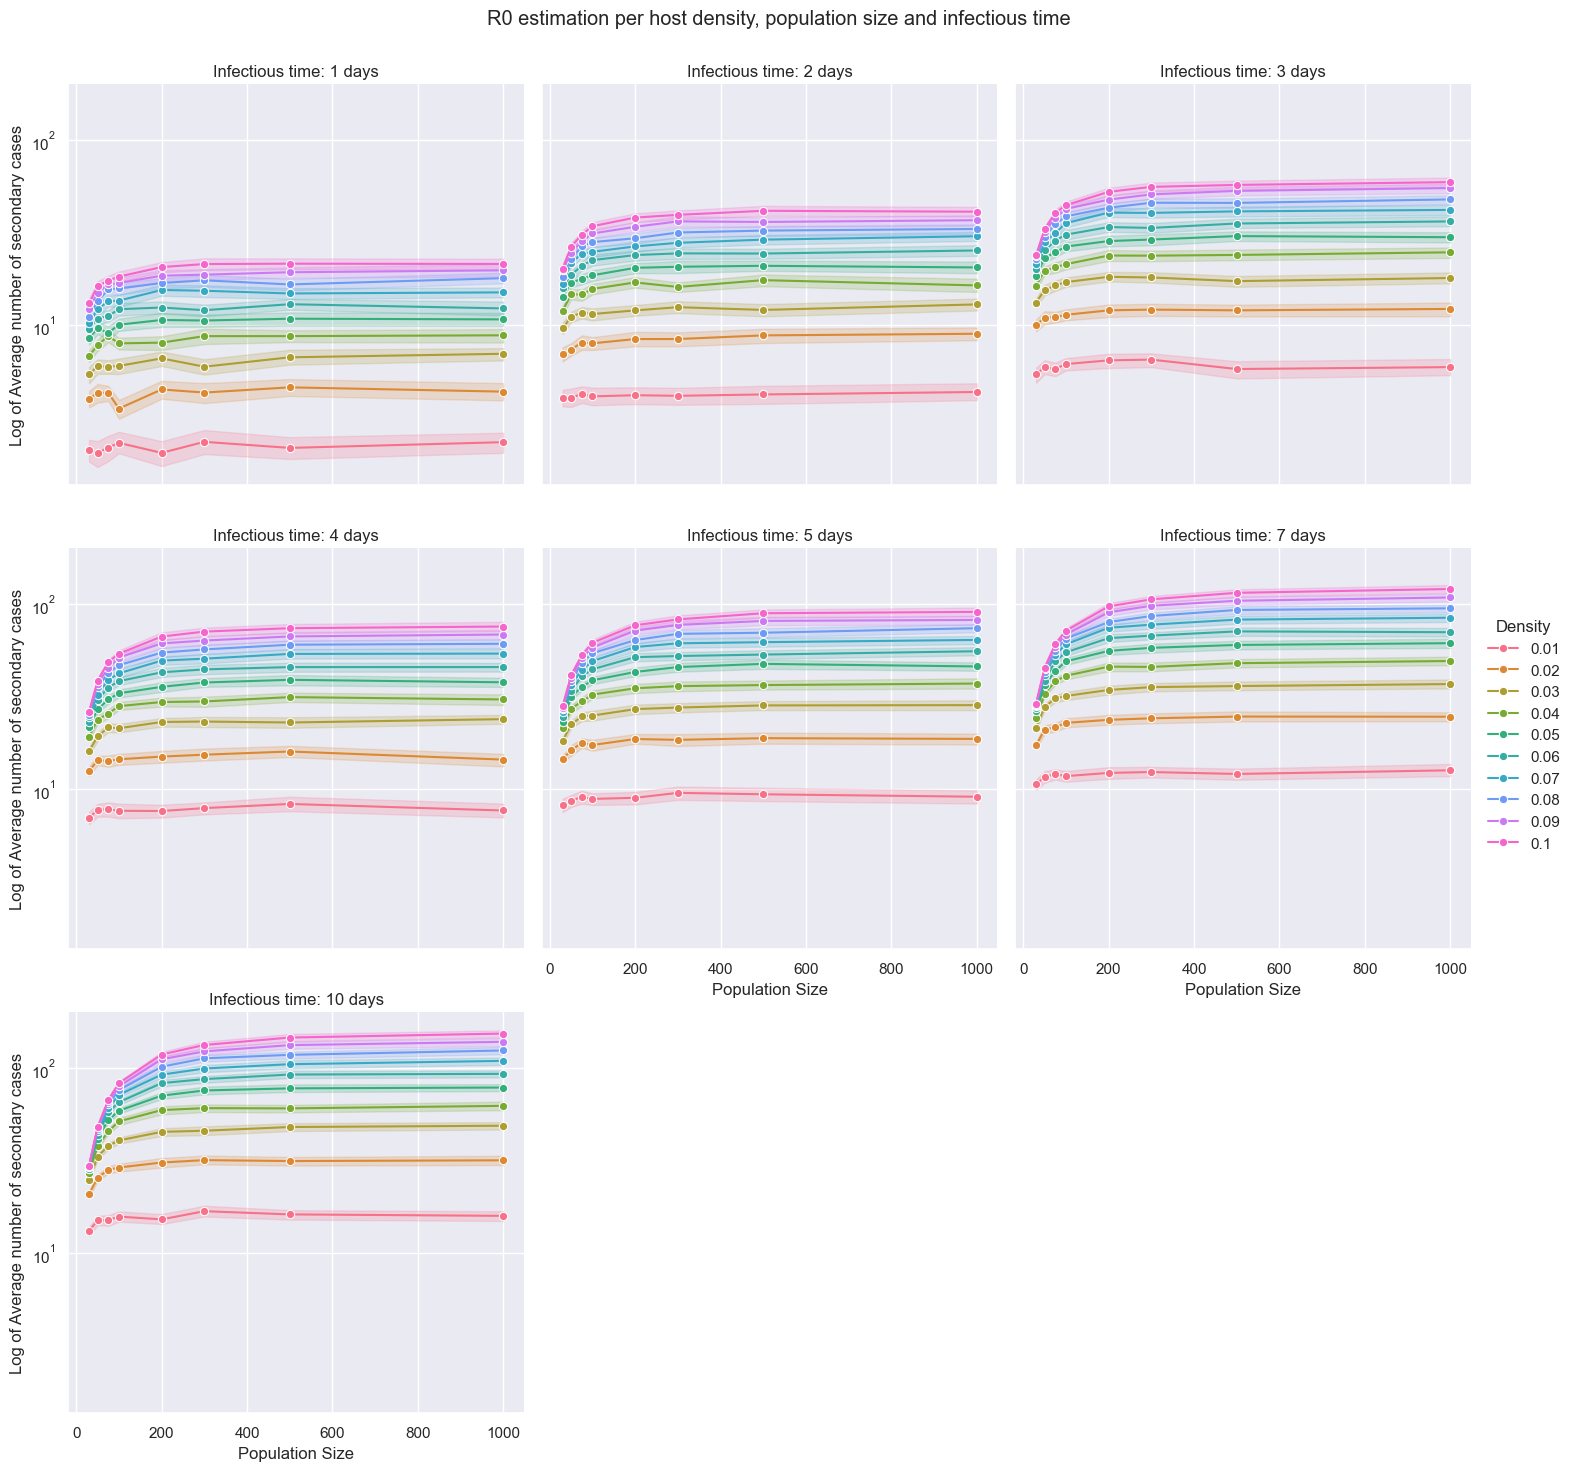

In [6]:
# Plot with FacetGrid
g = sns.FacetGrid(long_data, col="Infectious_time", col_wrap=3, height=5)
g.map(sns.lineplot, "Population_size", "cases", hue="Density", data=long_data, palette='husl', marker='o', legend= 'auto', estimator = "mean", errorbar= ("ci", 95))
g.set_axis_labels("Population Size", "Log of Average number of secondary cases")
g.set_titles("Infectious time: {col_name} days")
g.set(yscale='log')
g.add_legend(title='Density')
g.fig.suptitle("R0 estimation per host density, population size and infectious time")
plt.subplots_adjust(top=0.93)
plt.show()
g.savefig("R0_estimation_plot.png")

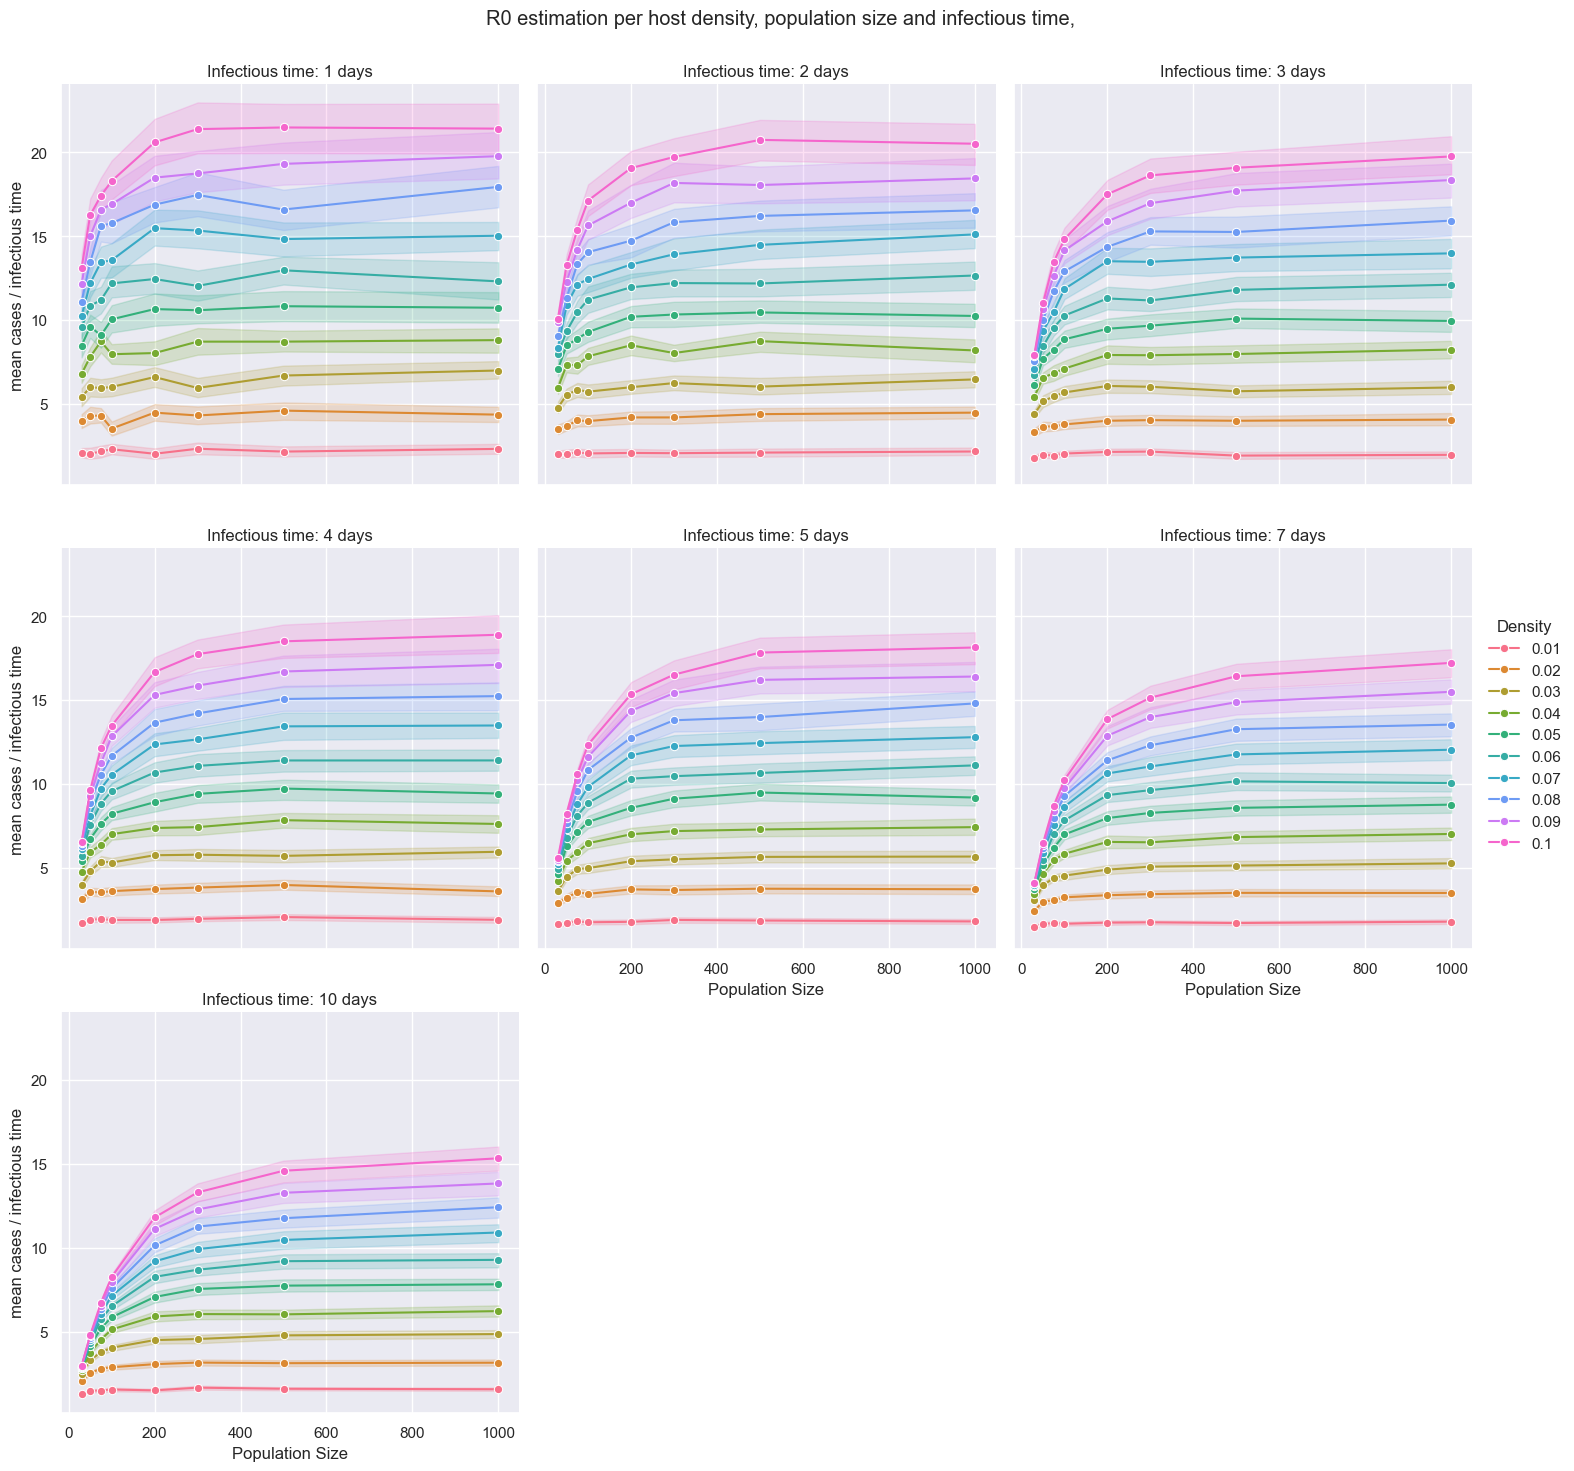

In [7]:
# Plot with FacetGrid
g1 = sns.FacetGrid(long_data, col="Infectious_time", col_wrap=3, height=5)
g1.map(sns.lineplot, "Population_size", "cases_per_infectious_time", hue="Density", data=long_data, palette='husl', marker='o', legend= 'auto', estimator = "mean", errorbar= ("ci", 95))
g1.set_axis_labels("Population Size", "mean cases / infectious time")
g1.set_titles("Infectious time: {col_name} days")
g1.add_legend(title='Density')
g1.fig.suptitle("R0 estimation per host density, population size and infectious time,")
plt.subplots_adjust(top=0.93)
plt.show()
g1.savefig("R0_estimation_plot_1.png")

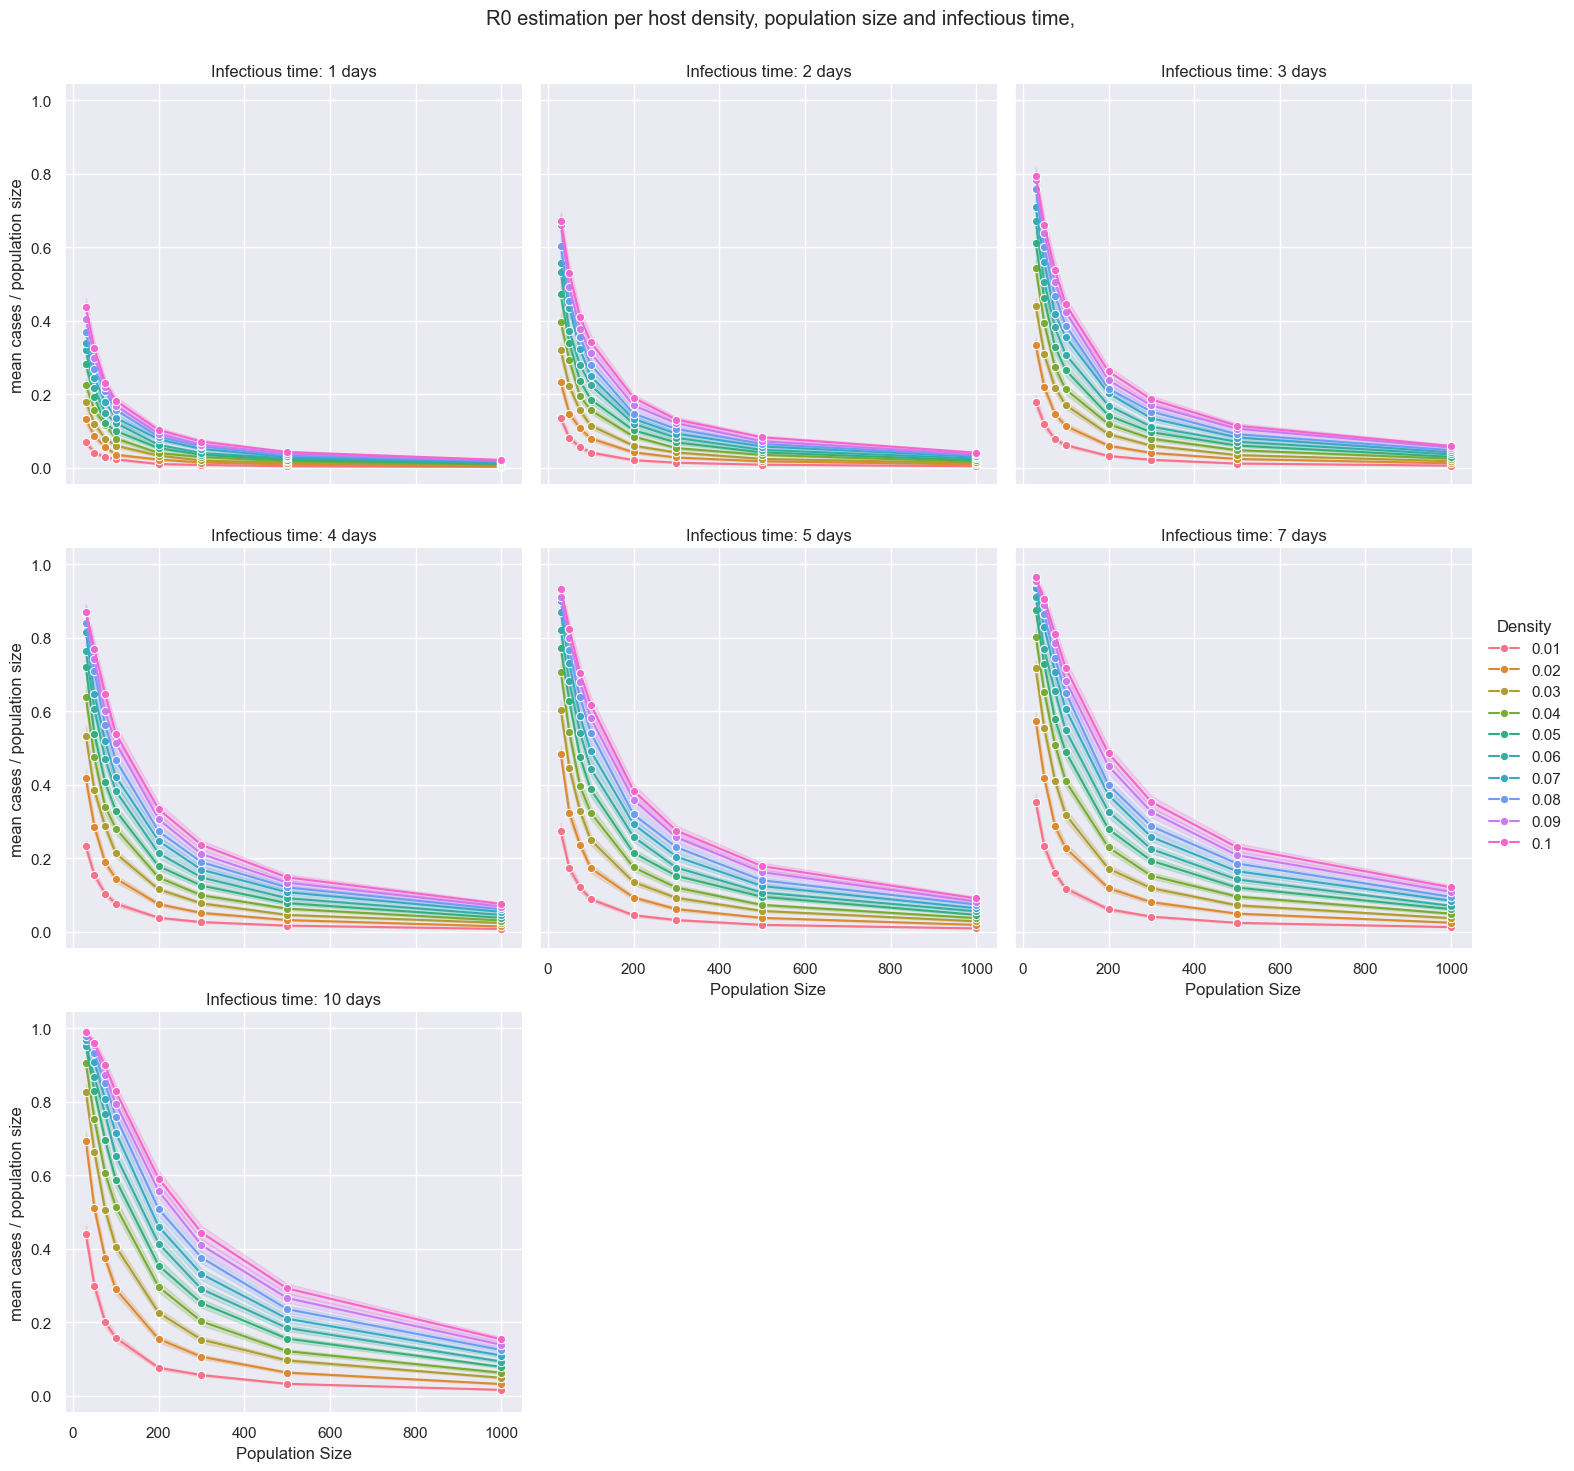

In [8]:
# Plot with FacetGrid
g2 = sns.FacetGrid(long_data, col="Infectious_time", col_wrap=3, height=5)
g2.map(sns.lineplot, "Population_size", "cases_per_pop_size", hue="Density", data=long_data, palette='husl', marker='o', legend= 'auto', estimator = "mean", errorbar= ("ci", 95))
g2.set_axis_labels("Population Size", "mean cases / population size")
g2.set_titles("Infectious time: {col_name} days")
g2.add_legend(title='Density')
g2.fig.suptitle("R0 estimation per host density, population size and infectious time,")
plt.subplots_adjust(top=0.93)
plt.show()
g2.savefig("R0_estimation_plot_2.png")

In [9]:
mean_data = long_data.groupby(["Infectious_time", "Population_size", "Density"])["cases"].mean().reset_index()
print(mean_data.dtypes)
mean_data.head()

Infectious_time    category
Population_size    category
Density            category
cases               float64
dtype: object


C:\Users\U117-T408\AppData\Local\Temp\ipykernel_21400\702118237.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_data = long_data.groupby(["Infectious_time", "Population_size", "Density"])["cases"].mean().reset_index()


,Infectious_time,Population_size,Density,cases
0,1,30,0.01,2.11
1,1,30,0.02,3.99
2,1,30,0.03,5.41
3,1,30,0.04,6.80
4,1,30,0.05,8.48


In [10]:
# Define a function to calculate confidence interval
def calculate_ci(data):
    mean = np.mean(data)
    std_error = np.std(data) / np.sqrt(len(data))
    lower_bound, upper_bound = norm.interval(0.95, loc=mean, scale=std_error)
    return lower_bound, upper_bound

# Apply the function to the 'cases' column within each group
CI_data = long_data.groupby(["Infectious_time", "Population_size", "Density"])["cases"].agg(['mean', lambda x: calculate_ci(x)]).reset_index()

# Rename columns
CI_data.columns = ['Infectious_time', 'Population_size', 'Density', 'mean_cases', 'CI']

# Split CI into lower and upper bounds
CI_data[['lower_bound', 'upper_bound']] = pd.DataFrame(CI_data['CI'].tolist(), index=mean_data.index)

# Drop the 'CI' column if no longer needed
CI_data.drop(columns=['CI'], inplace=True)

CI_data.head()

C:\Users\U117-T408\AppData\Local\Temp\ipykernel_21400\1165519698.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  CI_data = long_data.groupby(["Infectious_time", "Population_size", "Density"])["cases"].agg(['mean', lambda x: calculate_ci(x)]).reset_index()


,Infectious_time,Population_size,Density,mean_cases,lower_bound,upper_bound
0,1,30,0.01,2.11,1.823423,2.396577
1,1,30,0.02,3.99,3.571012,4.408988
2,1,30,0.03,5.41,4.863950,5.956050
3,1,30,0.04,6.80,6.279225,7.320775
4,1,30,0.05,8.48,7.824961,9.135039


In [8]:
# Merge the two csv files

df1 = pd.read_csv("simulation_results_v6.csv")

df2 = pd.read_csv("simulation_results_v5.csv")


In [10]:
df1_cleaned =  df1[~df1['Density'].isin([0.1, 0.01])]

df1_cleaned.to_csv("simulation_results_v6_cleaned.csv", index=False)

In [11]:
combined_df = pd.concat([df2, df1_cleaned])
combined_df.head()

,Density,Population_size,Infectious_time,iter_1,iter_2,iter_3,iter_4,iter_5,iter_6,iter_7,...,iter_91,iter_92,iter_93,iter_94,iter_95,iter_96,iter_97,iter_98,iter_99,iter_100
0,0.01,30,1,3,1,1,1,2,2,2,...,0,3,0,0,7,4,1,1,0,0
1,0.01,30,2,7,2,4,4,3,5,6,...,2,6,2,5,5,4,1,4,8,2
2,0.01,30,3,10,6,2,8,7,4,1,...,3,10,1,2,10,5,1,8,9,4
3,0.01,30,4,8,6,4,13,7,4,9,...,8,9,5,8,14,5,7,6,4,8
4,0.01,30,5,12,6,10,12,9,3,14,...,5,12,3,8,10,13,8,5,10,8


In [14]:
sorted_df = combined_df.sort_values(by=['Density', 'Population_size', 'Infectious_time'])


sorted_df.to_csv("simulation_results_all.csv", index=False)

sorted_df.head()

,Density,Population_size,Infectious_time,iter_1,iter_2,iter_3,iter_4,iter_5,iter_6,iter_7,...,iter_91,iter_92,iter_93,iter_94,iter_95,iter_96,iter_97,iter_98,iter_99,iter_100
0,0.01,30,1,3,1,1,1,2,2,2,...,0,3,0,0,7,4,1,1,0,0
1,0.01,30,2,7,2,4,4,3,5,6,...,2,6,2,5,5,4,1,4,8,2
2,0.01,30,3,10,6,2,8,7,4,1,...,3,10,1,2,10,5,1,8,9,4
3,0.01,30,4,8,6,4,13,7,4,9,...,8,9,5,8,14,5,7,6,4,8
4,0.01,30,5,12,6,10,12,9,3,14,...,5,12,3,8,10,13,8,5,10,8


In [16]:
long_data_all = pd.melt(sorted_df, var_name="simulation", value_name="cases", 
                   id_vars=[col for col in sorted_df.columns if not col.startswith("iter")])

long_data_all['cases_per_infectious_time'] = long_data_all['cases'] / long_data_all['Infectious_time']
long_data_all['cases_per_pop_size'] = long_data_all['cases'] / long_data_all['Population_size']

long_data_all['Infectious_time'] = long_data_all['Infectious_time'].astype('category')
long_data_all['Population_size'] = long_data_all['Population_size'].astype('category')
long_data_all['Density'] = long_data_all['Density'].astype('category')

print(long_data_all.dtypes)

long_data_all.head()

Density                      category
Population_size              category
Infectious_time              category
simulation                     object
cases                           int64
cases_per_infectious_time     float64
cases_per_pop_size            float64
dtype: object


,Density,Population_size,Infectious_time,simulation,cases,cases_per_infectious_time,cases_per_pop_size
0,0.01,30,1,iter_1,3,3.000000,0.100000
1,0.01,30,2,iter_1,7,3.500000,0.233333
2,0.01,30,3,iter_1,10,3.333333,0.333333
3,0.01,30,4,iter_1,8,2.000000,0.266667
4,0.01,30,5,iter_1,12,2.400000,0.400000


In [23]:
unique_levels = long_data_all['Density'].unique()

# Count the number of unique levels
num_levels = len(unique_levels)

num_levels

16

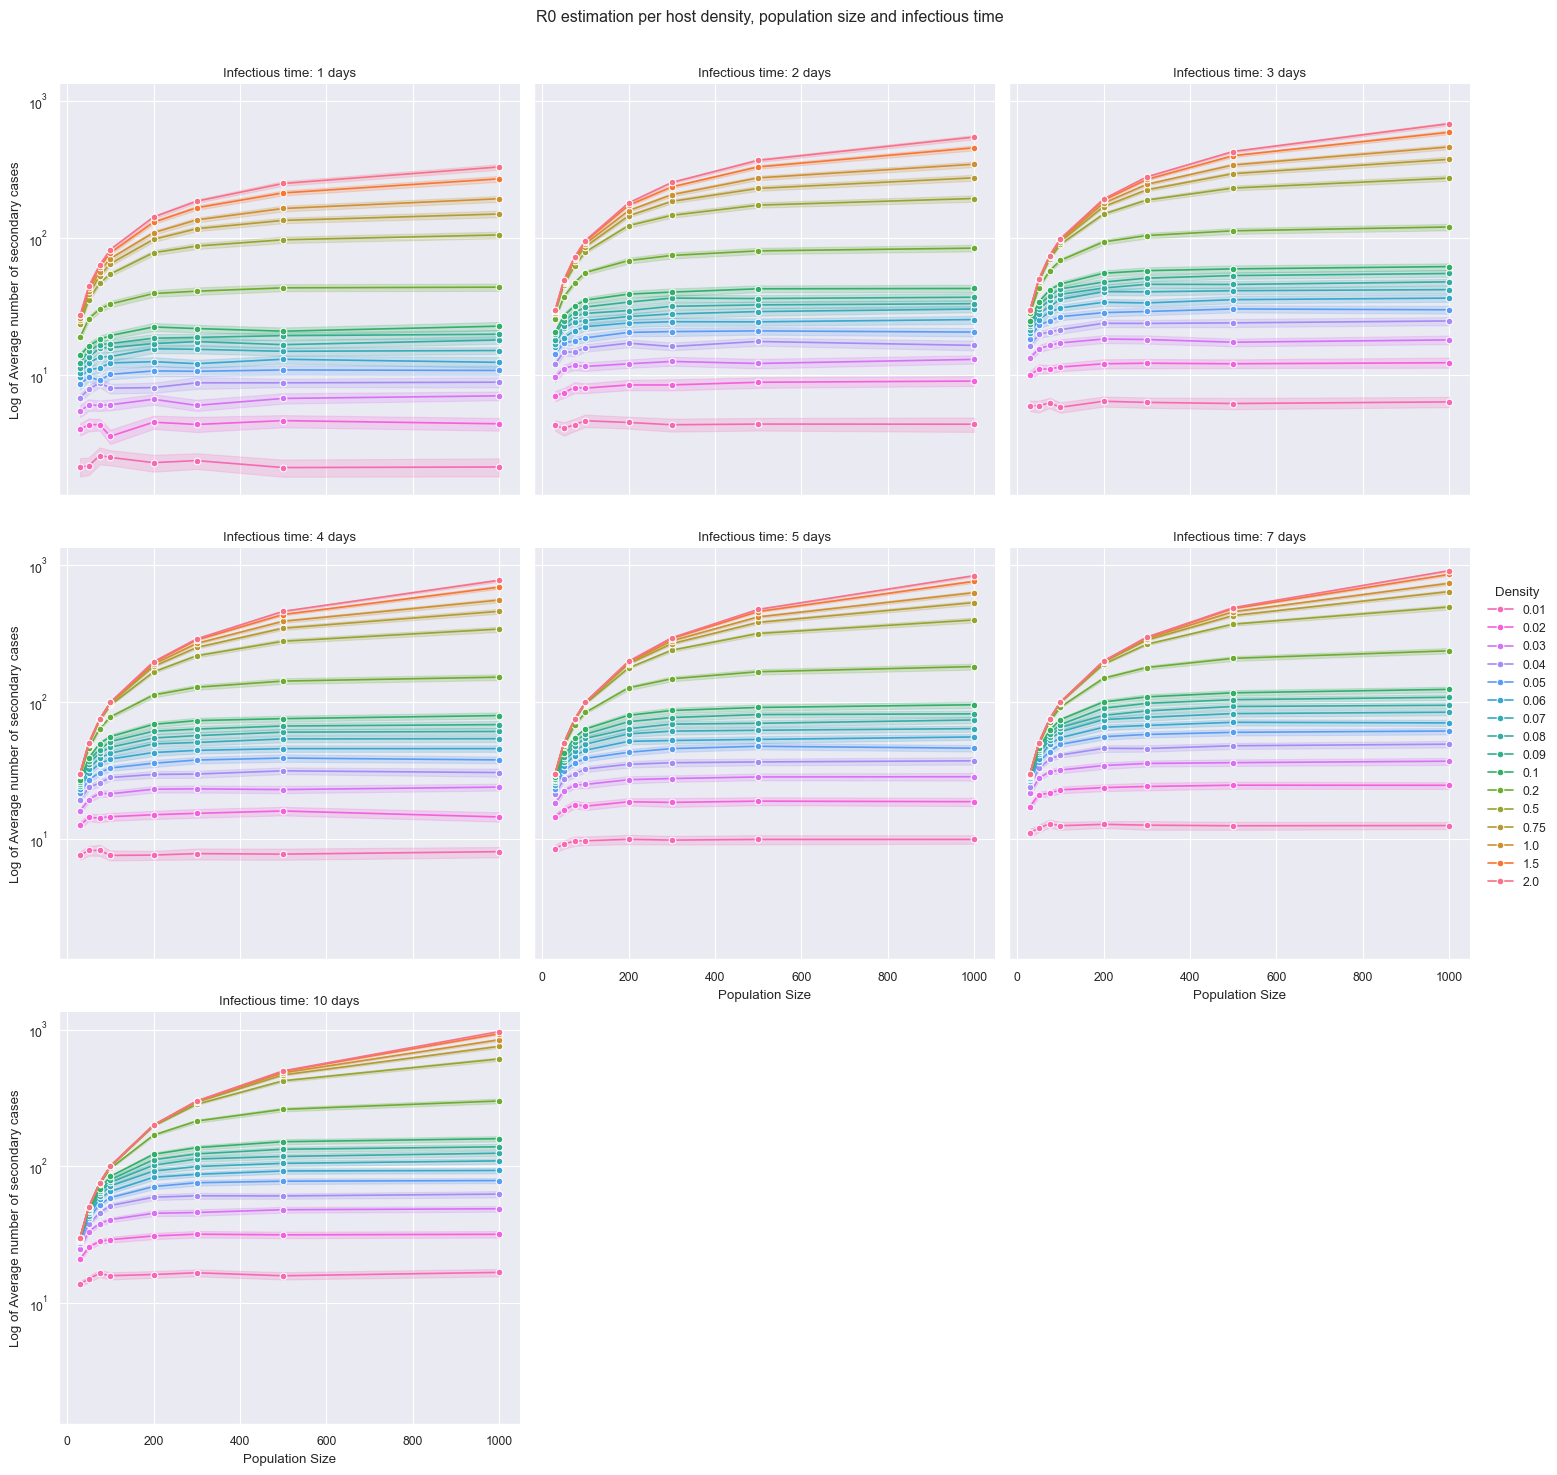

In [29]:
# Plot with FacetGrid
palette = sns.color_palette("husl", n_colors=16)
reversed_palette = palette[::-1]

g = sns.FacetGrid(long_data_all, col="Infectious_time", col_wrap=3, height=5)
g.map(sns.lineplot, "Population_size", "cases", hue="Density", data=long_data_all, palette=reversed_palette, marker='o', legend= 'auto', estimator = "mean", errorbar= ("ci", 95))
g.set_axis_labels("Population Size", "Log of Average number of secondary cases")
g.set_titles("Infectious time: {col_name} days")
g.set(yscale='log')
g.add_legend(title='Density')
g.fig.suptitle("R0 estimation per host density, population size and infectious time")
plt.subplots_adjust(top=0.93)
plt.show()
g.savefig("R0_estimation_plot_all.png")